# Crop detection from satellite imagery using deep learning

This is a notebook to describe first place solution for ICLR Workshop Challenge #2: Radiant Earth Computer Vision for Crop Detection from Satellite Imagery.
You can find the original code here: https://github.com/karimmamer/CropDetectionDL

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import StratifiedShuffleSplit
from utils import load_file

## Downloading the data

In [2]:
data_path = '.'

In [3]:
from radiant_mlhub import Dataset
dataset = Dataset.fetch('ref_african_crops_kenya_02')
source_collection = dataset.collections.source_imagery[0]
source_collection.download(data_path)
lbl_collection = dataset.collections.labels[0]
lbl_collection.download(data_path)

PosixPath('/home/karim/Documents/ml4eo2021/ref_african_crops_kenya_01_labels.tar.gz')

In [4]:
import tarfile
def untar_data(fname):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [5]:
untar_data('ref_african_crops_kenya_02_source.tar.gz')
untar_data('ref_african_crops_kenya_02_labels.tar.gz')

You need to download also the sample submission file from here: https://zindi.africa/competitions/iclr-workshop-challenge-2-radiant-earth-computer-vision-for-crop-recognition/data

## Data preparation

Firstly, we will prepare the dataset by cropping small patches of 32X32 around each field as the original images are huge and most of its area are not included in training nor test data.

In [6]:
# List of dates that an observation from Sentinel-2 is provided in the training dataset
dates = [datetime.datetime(2019, 6, 6, 8, 10, 7),
         datetime.datetime(2019, 7, 1, 8, 10, 4),
         datetime.datetime(2019, 7, 6, 8, 10, 8),
         datetime.datetime(2019, 7, 11, 8, 10, 4),
         datetime.datetime(2019, 7, 21, 8, 10, 4),
         datetime.datetime(2019, 8, 5, 8, 10, 7),
         datetime.datetime(2019, 8, 15, 8, 10, 6),
         datetime.datetime(2019, 8, 25, 8, 10, 4),
         datetime.datetime(2019, 9, 9, 8, 9, 58),
         datetime.datetime(2019, 9, 19, 8, 9, 59),
         datetime.datetime(2019, 9, 24, 8, 9, 59),
         datetime.datetime(2019, 10, 4, 8, 10),
         datetime.datetime(2019, 11, 3, 8, 10)]

# List of bands names included in the dataset
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']

Reading the data

In [7]:
bands_arr = np.zeros((4,13,13,3035,2016), dtype = np.float32) # 4 tiles X 13 days X 13 bands X 3035 pixels X 2016 pixels
#read all images
for tile in range(4):
    for idx, d in enumerate(dates): # 2) For each date
        d = ''.join(str(d.date()).split('-')) # Nice date string
        t = '0'+str(tile)
        for ibx, b in enumerate(bands): # 3) For each band
            # Load im
            #im = load_file(f"{data_path}/{t}/{d}/{t[1]}_{b}_{d}.tif").astype(np.float32)
            im = load_file(f"{data_path}/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_{t}_{d}/{b}.tif").astype(np.float32)
            bands_arr[tile,idx,ibx] = im

In [8]:
def create_dataset(bands_arr, radius):
    """
    This a function that go through each field in the data and crop a (2*radius)X(2*radius) patch.
    """
    imgs = np.zeros((4688,13,13,radius*2,radius*2), dtype = np.float32) # patches matrix of dataset_size X 13 days X 13 bands X (2*radius)X(2*radius)
    areas = np.zeros((4688,), dtype = np.int) # it has the area of each field in the dataset
    gts = np.zeros((4688,), dtype = np.int) # it has the ground truth of each field in the dataset
    field_masks = np.zeros((4688,1,radius*2,radius*2), dtype = np.float32) # fields matrix that has ones for the pixel belongs to the field, zeros otherwith of dataset_size X (2*radius)X(2*radius)
    fields_arr = []
    ifx = 0
    
    for tile in range(4):
        #load field id and label matrices of the tile
        fids = f'{data_path}/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_0{tile}_label/field_ids.tif'
        labs = f'{data_path}/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_0{tile}_label/labels.tif'
        field_id = load_file(fids)
        labels = load_file(labs)
        
        for field in np.unique(field_id):
            if field == 0: # if a pixel has 0 as an ID, it means it is not included neither in training nor test data.
              continue
            fields_arr.append(field)
            
            #find pixels belong to current field id
            area_mask = field_id == field
            
            #extract ground-truth class
            area_gt = np.unique(labels[area_mask])[0] 
            
            #calculate the median pixel position to crop around it
            idxx = np.where(area_mask)
            momentx = np.median(idxx[0]).astype(np.int)
            momenty = np.median(idxx[1]).astype(np.int)
            
            #create crop
            patch = bands_arr[tile,:,:,max(0, momentx-radius): momentx+radius, max(0, momenty-radius): momenty+radius]
            
            #pad crops in tiles borders with zeros
            imgs[ifx, :, :, :patch.shape[-2], :patch.shape[-1]] = patch
            
            #create crop's field mask (1s for pixels belong to current field id and zeros otherwise)
            field_patch = area_mask[max(0, momentx-radius): momentx+radius, max(0, momenty-radius): momenty+radius]
            
            #pad crop's field mask in tiles borders with zeros
            field_masks[ifx, 0, :patch.shape[-2], :patch.shape[-1]] = field_patch
            
            #make sure the crop's field mask is not empty
            if field_patch.sum() == 0:
                print(ifx, momentx-radius, momentx+radius, momenty-radius, momenty+radius)
            
            #calculate field area
            areas[ifx] = area_mask.sum()
            gts[ifx] = area_gt - 1
            ifx += 1
    
    return imgs, areas, gts, field_masks, fields_arr

In [9]:
#create crops of 32X32 around each field id center
imgs, areas, gts, field_masks, fields_arr = create_dataset(bands_arr, 16)

## Data exploration

In [10]:
plt.rcParams["figure.figsize"] = (15,10)

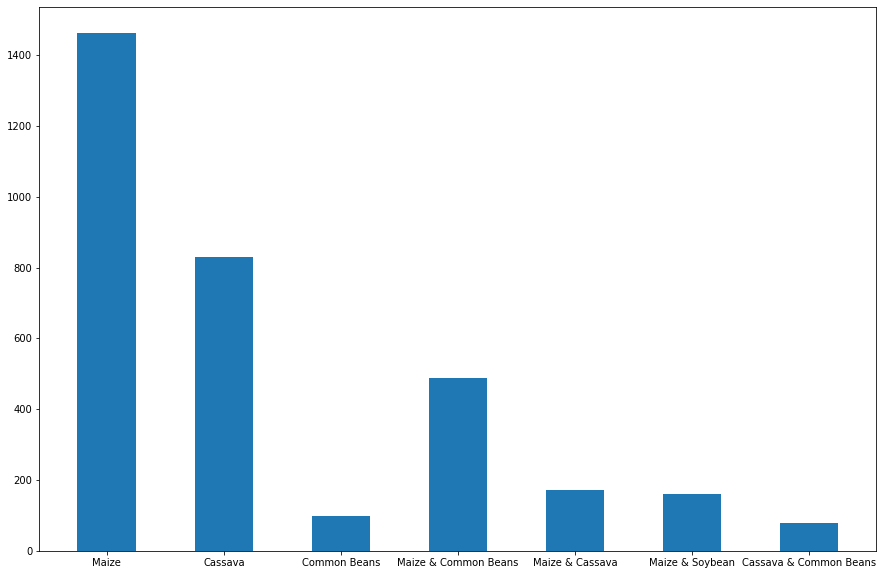

In [11]:
_, counts = np.unique(gts[gts > -1], return_counts=True)
labels = ['Maize', 'Cassava', 'Common Beans', 'Maize & Common Beans', 'Maize & Cassava', 'Maize & Soybean', 'Cassava & Common Beans']
plt.bar(labels, counts, align='center', width = 0.5)
plt.gca().set_xticks(labels)
plt.show()

Text(0, 0.5, 'No. samples')

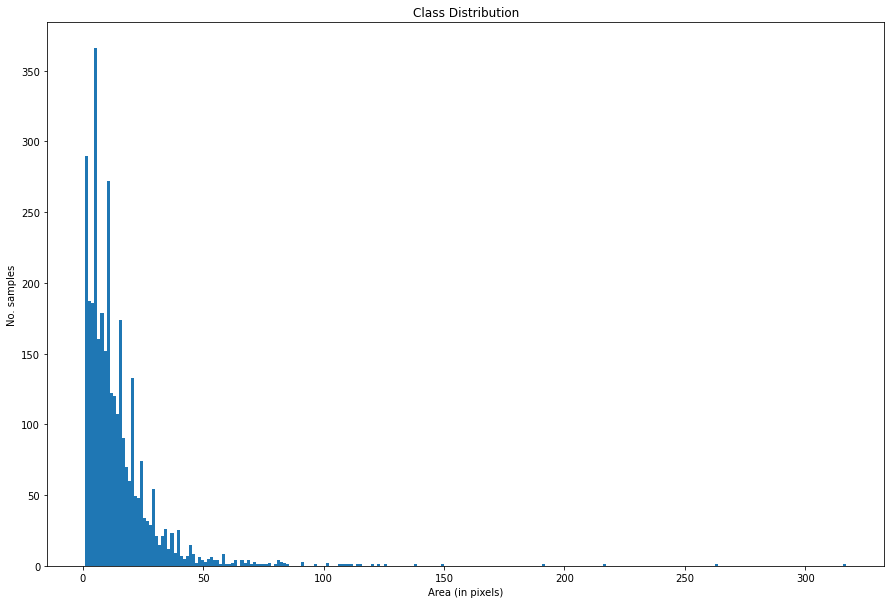

In [12]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(areas[gts > -1], bins=250)
plt.title('Class Distribution')
plt.xlabel('Area (in pixels)')
plt.ylabel('No. samples')

In [13]:
band_skewness = []
band_skewness_after_sqrt = []
for c in range(13):
    #calculate skewness
    band_skewness.append(pd.Series(imgs[:,:,c].flatten()).skew())
    #calculate skewness after applying sqrt
    band_skewness_after_sqrt.append(pd.Series(np.sqrt(imgs[:,:,c].flatten())).skew())

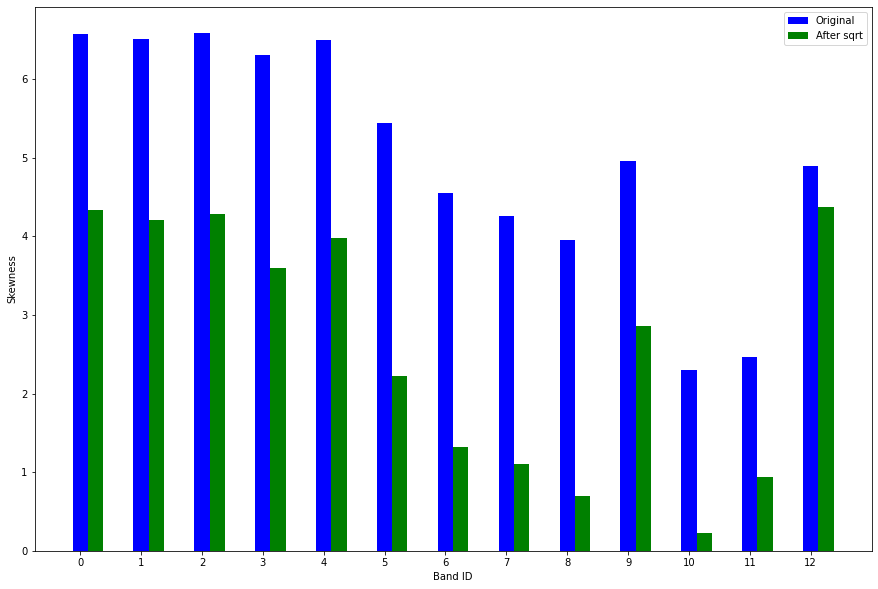

In [14]:
width = 0.25

rng = [i for i in range(0,13)]
rng2 = [i+width for i in range(0,13)]

plt.bar(rng, band_skewness, align='center', width = width, label='Original', color ='b')
plt.bar(rng2, band_skewness_after_sqrt, align='center', width = width, label='After sqrt', color ='g')
plt.gca().set_xticks(rng)
plt.legend()
plt.xlabel('Band ID')
plt.ylabel('Skewness')
plt.show()

## Data preprocessing

In [7]:
#generate vegitation indecies for training and testing data
ndvi = (imgs[:,:,7:8,:,:] - imgs[:,:,3:4,:,:]) / (imgs[:,:,7:8,:,:] + imgs[:,:,3:4,:,:] + 1e-6)
ndwi_green = (imgs[:,:,2:3,:,:] - imgs[:,:,7:8,:,:]) / (imgs[:,:,2:3,:,:] + imgs[:,:,7:8,:,:] + 1e-6)
ndwi_blue = (imgs[:,:,1:2,:,:] - imgs[:,:,7:8,:,:]) / (imgs[:,:,1:2,:,:] + imgs[:,:,7:8,:,:] + 1e-6)

In [8]:
#apply sqrt to lower skewness
imgs = np.sqrt(imgs)

In [9]:
imgs = np.concatenate([imgs, ndvi, ndwi_green, ndwi_blue], axis = 2)

In [10]:
#data standardization
for c in range(imgs.shape[2]):
    mean = imgs[:, :, c].mean()
    std = imgs[:, :, c].std()
    imgs[:, :, c] = (imgs[:, :, c] - mean) / std

## Local validation strategy

In [11]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

## Model training

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from dataset import ICLRDataset
from model import ConvGRUNet
from utils import test, train_model_snapshot

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#set all seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
models_arr = []
fold = 0
for train_index, val_index in sss.split(areas[gts > -1], gts[gts > -1]):
    print(fold)
    fold += 1
    image_datasets = {'train': ICLRDataset(imgs, areas, gts, field_masks, 'train', train_index),
                      'val': ICLRDataset(imgs, areas, gts, field_masks, 'val', val_index),
                      'test': ICLRDataset(imgs, areas, gts, field_masks, 'test', None)}

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=16),
                   'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=False, num_workers=16)}

    model_ft = ConvGRUNet(imgs.shape[2]-1)
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
    
    #train a model on this data split using snapshot ensemble
    model_ft_arr, _, _ = train_model_snapshot(model_ft, criterion, 0.008, dataloaders, dataset_sizes, device,
                           num_cycles=6, num_epochs_per_cycle=10)
    models_arr.extend(model_ft_arr)

0
Cycle 0: Epoch 0/9
----------
train Loss: 1.4757 Acc: 0.4654
val Loss: 1.3832 Acc: 0.5416

Cycle 0: Epoch 1/9
----------
train Loss: 1.3736 Acc: 0.5156
val Loss: 1.3560 Acc: 0.5497

Cycle 0: Epoch 2/9
----------
train Loss: 1.3376 Acc: 0.5313
val Loss: 1.3826 Acc: 0.5152

Cycle 0: Epoch 3/9
----------
train Loss: 1.3149 Acc: 0.5313
val Loss: 1.3509 Acc: 0.5396

Cycle 0: Epoch 4/9
----------
train Loss: 1.2937 Acc: 0.5446
val Loss: 1.2723 Acc: 0.5619

Cycle 0: Epoch 5/9
----------
train Loss: 1.2616 Acc: 0.5589
val Loss: 1.2528 Acc: 0.5700

Cycle 0: Epoch 6/9
----------
train Loss: 1.2251 Acc: 0.5700
val Loss: 1.2100 Acc: 0.5740

Cycle 0: Epoch 7/9
----------
train Loss: 1.1989 Acc: 0.5829
val Loss: 1.2071 Acc: 0.5822

Cycle 0: Epoch 8/9
----------
train Loss: 1.1781 Acc: 0.5850
val Loss: 1.2071 Acc: 0.5700

Cycle 0: Epoch 9/9
----------
train Loss: 1.1759 Acc: 0.5908
val Loss: 1.2072 Acc: 0.5680

Cycle 1: Epoch 0/9
----------
train Loss: 1.2775 Acc: 0.5517
val Loss: 1.2422 Acc: 0.565

train Loss: 1.0412 Acc: 0.6334
val Loss: 1.0904 Acc: 0.6085

Cycle 3: Epoch 0/9
----------
train Loss: 1.1483 Acc: 0.5965
val Loss: 1.1482 Acc: 0.6105

Cycle 3: Epoch 1/9
----------
train Loss: 1.1341 Acc: 0.5933
val Loss: 1.1995 Acc: 0.5882

Cycle 3: Epoch 2/9
----------
train Loss: 1.1285 Acc: 0.6076
val Loss: 1.1609 Acc: 0.5822

Cycle 3: Epoch 3/9
----------
train Loss: 1.1068 Acc: 0.6108
val Loss: 1.1547 Acc: 0.5903

Cycle 3: Epoch 4/9
----------
train Loss: 1.0719 Acc: 0.6273
val Loss: 1.1142 Acc: 0.5943

Cycle 3: Epoch 5/9
----------
train Loss: 1.0584 Acc: 0.6269
val Loss: 1.1243 Acc: 0.5984

Cycle 3: Epoch 6/9
----------
train Loss: 1.0170 Acc: 0.6377
val Loss: 1.1104 Acc: 0.6268

Cycle 3: Epoch 7/9
----------
train Loss: 1.0094 Acc: 0.6409
val Loss: 1.0896 Acc: 0.6187

Cycle 3: Epoch 8/9
----------
train Loss: 0.9979 Acc: 0.6480
val Loss: 1.0854 Acc: 0.6227

Cycle 3: Epoch 9/9
----------
train Loss: 0.9797 Acc: 0.6495
val Loss: 1.0853 Acc: 0.6247

Cycle 4: Epoch 0/9
----------

val Loss: 1.2129 Acc: 0.5700

Cycle 5: Epoch 9/9
----------
train Loss: 0.8254 Acc: 0.7114
val Loss: 1.2144 Acc: 0.5740

Training complete in 9m 30s
Ensemble Loss : 1.145610, Best val Loss: 1.158862
3
Cycle 0: Epoch 0/9
----------
train Loss: 1.4946 Acc: 0.4608
val Loss: 1.3850 Acc: 0.5193

Cycle 0: Epoch 1/9
----------
train Loss: 1.4024 Acc: 0.5120
val Loss: 1.3466 Acc: 0.5456

Cycle 0: Epoch 2/9
----------
train Loss: 1.3641 Acc: 0.5270
val Loss: 1.2863 Acc: 0.5538

Cycle 0: Epoch 3/9
----------
train Loss: 1.3421 Acc: 0.5277
val Loss: 1.2821 Acc: 0.5517

Cycle 0: Epoch 4/9
----------
train Loss: 1.3105 Acc: 0.5346
val Loss: 1.2729 Acc: 0.5456

Cycle 0: Epoch 5/9
----------
train Loss: 1.2835 Acc: 0.5478
val Loss: 1.3145 Acc: 0.5416

Cycle 0: Epoch 6/9
----------
train Loss: 1.2641 Acc: 0.5539
val Loss: 1.2246 Acc: 0.5862

Cycle 0: Epoch 7/9
----------
train Loss: 1.2273 Acc: 0.5696
val Loss: 1.2095 Acc: 0.5740

Cycle 0: Epoch 8/9
----------
train Loss: 1.2110 Acc: 0.5696
val Loss: 

train Loss: 1.0543 Acc: 0.6323
val Loss: 1.1488 Acc: 0.5984

Cycle 2: Epoch 8/9
----------
train Loss: 1.0413 Acc: 0.6301
val Loss: 1.1430 Acc: 0.6024

Cycle 2: Epoch 9/9
----------
train Loss: 1.0314 Acc: 0.6319
val Loss: 1.1417 Acc: 0.5963

Cycle 3: Epoch 0/9
----------
train Loss: 1.1592 Acc: 0.5854
val Loss: 1.2328 Acc: 0.5578

Cycle 3: Epoch 1/9
----------
train Loss: 1.1343 Acc: 0.6076
val Loss: 1.2156 Acc: 0.5740

Cycle 3: Epoch 2/9
----------
train Loss: 1.1232 Acc: 0.5961
val Loss: 1.1911 Acc: 0.5923

Cycle 3: Epoch 3/9
----------
train Loss: 1.1037 Acc: 0.6126
val Loss: 1.1892 Acc: 0.5882

Cycle 3: Epoch 4/9
----------
train Loss: 1.0784 Acc: 0.6208
val Loss: 1.1555 Acc: 0.6004

Cycle 3: Epoch 5/9
----------
train Loss: 1.0421 Acc: 0.6334
val Loss: 1.1469 Acc: 0.5984

Cycle 3: Epoch 6/9
----------
train Loss: 1.0128 Acc: 0.6402
val Loss: 1.1694 Acc: 0.5963

Cycle 3: Epoch 7/9
----------
train Loss: 0.9932 Acc: 0.6473
val Loss: 1.1549 Acc: 0.6045

Cycle 3: Epoch 8/9
----------

val Loss: 1.1434 Acc: 0.6085

Cycle 5: Epoch 7/9
----------
train Loss: 0.8632 Acc: 0.6835
val Loss: 1.1616 Acc: 0.6004

Cycle 5: Epoch 8/9
----------
train Loss: 0.8306 Acc: 0.6942
val Loss: 1.1584 Acc: 0.6045

Cycle 5: Epoch 9/9
----------
train Loss: 0.8171 Acc: 0.6985
val Loss: 1.1616 Acc: 0.6085

Training complete in 9m 24s
Ensemble Loss : 1.121903, Best val Loss: 1.130940
6
Cycle 0: Epoch 0/9
----------
train Loss: 1.4740 Acc: 0.4658
val Loss: 1.3861 Acc: 0.5132

Cycle 0: Epoch 1/9
----------
train Loss: 1.3899 Acc: 0.5141
val Loss: 1.3684 Acc: 0.5193

Cycle 0: Epoch 2/9
----------
train Loss: 1.3408 Acc: 0.5292
val Loss: 1.3173 Acc: 0.5497

Cycle 0: Epoch 3/9
----------
train Loss: 1.3060 Acc: 0.5410
val Loss: 1.2781 Acc: 0.5416

Cycle 0: Epoch 4/9
----------
train Loss: 1.2696 Acc: 0.5607
val Loss: 1.3315 Acc: 0.5193

Cycle 0: Epoch 5/9
----------
train Loss: 1.2541 Acc: 0.5639
val Loss: 1.2596 Acc: 0.5497

Cycle 0: Epoch 6/9
----------
train Loss: 1.2113 Acc: 0.5811
val Loss: 

train Loss: 1.0922 Acc: 0.6079
val Loss: 1.1883 Acc: 0.5943

Cycle 2: Epoch 6/9
----------
train Loss: 1.0662 Acc: 0.6194
val Loss: 1.1455 Acc: 0.6045

Cycle 2: Epoch 7/9
----------
train Loss: 1.0595 Acc: 0.6173
val Loss: 1.1580 Acc: 0.6004

Cycle 2: Epoch 8/9
----------
train Loss: 1.0287 Acc: 0.6395
val Loss: 1.1475 Acc: 0.6065

Cycle 2: Epoch 9/9
----------
train Loss: 1.0191 Acc: 0.6412
val Loss: 1.1483 Acc: 0.6065

Cycle 3: Epoch 0/9
----------
train Loss: 1.1537 Acc: 0.5865
val Loss: 1.3579 Acc: 0.5375

Cycle 3: Epoch 1/9
----------
train Loss: 1.1421 Acc: 0.5983
val Loss: 1.2624 Acc: 0.5822

Cycle 3: Epoch 2/9
----------
train Loss: 1.1141 Acc: 0.6058
val Loss: 1.2067 Acc: 0.5984

Cycle 3: Epoch 3/9
----------
train Loss: 1.1033 Acc: 0.6169
val Loss: 1.1538 Acc: 0.6085

Cycle 3: Epoch 4/9
----------
train Loss: 1.0534 Acc: 0.6280
val Loss: 1.1805 Acc: 0.6045

Cycle 3: Epoch 5/9
----------
train Loss: 1.0435 Acc: 0.6373
val Loss: 1.1704 Acc: 0.6146

Cycle 3: Epoch 6/9
----------

val Loss: 1.2069 Acc: 0.6085

Cycle 5: Epoch 5/9
----------
train Loss: 0.9272 Acc: 0.6645
val Loss: 1.1988 Acc: 0.5822

Cycle 5: Epoch 6/9
----------
train Loss: 0.8947 Acc: 0.6774
val Loss: 1.2012 Acc: 0.6024

Cycle 5: Epoch 7/9
----------
train Loss: 0.8549 Acc: 0.6975
val Loss: 1.1957 Acc: 0.6105

Cycle 5: Epoch 8/9
----------
train Loss: 0.8329 Acc: 0.7082
val Loss: 1.1840 Acc: 0.6085

Cycle 5: Epoch 9/9
----------
train Loss: 0.8064 Acc: 0.7204
val Loss: 1.1857 Acc: 0.6126

Training complete in 9m 42s
Ensemble Loss : 1.118529, Best val Loss: 1.127232
9
Cycle 0: Epoch 0/9
----------
train Loss: 1.4778 Acc: 0.4719
val Loss: 1.3919 Acc: 0.5172

Cycle 0: Epoch 1/9
----------
train Loss: 1.3727 Acc: 0.5213
val Loss: 1.3135 Acc: 0.5477

Cycle 0: Epoch 2/9
----------
train Loss: 1.3586 Acc: 0.5209
val Loss: 1.3237 Acc: 0.5436

Cycle 0: Epoch 3/9
----------
train Loss: 1.3270 Acc: 0.5403
val Loss: 1.3346 Acc: 0.5172

Cycle 0: Epoch 4/9
----------
train Loss: 1.2962 Acc: 0.5456
val Loss: 

## Model inference

In [17]:
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=16,shuffle=False, num_workers=4)
res = test(models_arr, test_loader, device)

## Make a submission

In [22]:
sample_submission_path = 'SampleSubmission.csv'
test_fields_arr = np.array(fields_arr)[gts == -1]
sub = pd.read_csv(sample_submission_path)
sub['Field_ID'] = test_fields_arr.tolist()
for i in range(res.shape[1]):
    sub['Crop_ID_%d'%(i+1)] = res[:,i].tolist()
sub.to_csv('sub.csv', index = False)

### You should achieve 1.114 on the leaderboard